<a href="https://colab.research.google.com/github/gr3g-z/TCC-PUCSP-CDIA/blob/main/SARIMA_D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00


In [4]:
# Libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import prophet
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
jan = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_January_2019.csv')
fev = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_February_2019.csv')
mar = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_March_2019.csv')
abr = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_April_2019.csv')
mai = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_May_2019.csv')
jun = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_June_2019.csv')
jul = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_July_2019.csv')
ago = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_August_2019.csv')
sep = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_September_2019.csv')
out = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_October_2019.csv')
nov = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_November_2019.csv')
dez = pd.read_csv('/content/drive/MyDrive/sales_data/Sales_December_2019.csv')

In [9]:
df = pd.concat([jan, fev, mar, abr, mai, jun, jul, ago, sep, out, nov, dez])
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"


In [10]:
df = df.dropna(axis = 0)

In [11]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"


In [12]:
# Converta a coluna 'Order Date' para datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y %H:%M', errors='coerce')

In [14]:
df = df.dropna(subset=['Order Date'])

In [15]:
df['Quantity Ordered'] = df['Quantity Ordered'].astype(int)
df['Price Each'] = df['Price Each'].astype(float)

In [16]:
df_cleaned = df.copy()

# Converta a coluna 'Order Date' para datetime
df_cleaned['Order Date'] = pd.to_datetime(df_cleaned['Order Date'], format='%m/%d/%y %H:%M', errors='coerce')

df_cleaned['Quantity Ordered'] = df_cleaned['Quantity Ordered'].astype(int)
df_cleaned['Price Each'] = df_cleaned['Price Each'].astype(float)

# Remova as linhas com valores não convertíveis
df_cleaned = df_cleaned.dropna(subset=['Order Date'])

In [17]:
df_cleaned['Total Spent'] = df['Quantity Ordered'] * df['Price Each']

In [18]:
produto_LightningCable = 'Wired Headphones'
# Filtrar o DataFrame original para incluir apenas o produto específico
df = df_cleaned[df_cleaned['Product'] == produto_LightningCable].copy()
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total Spent
2,141236,Wired Headphones,2,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",23.98
4,141238,Wired Headphones,1,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",11.99
36,141270,Wired Headphones,1,11.99,2019-01-27 23:10:00,"469 Hill St, San Francisco, CA 94016",11.99
39,141273,Wired Headphones,2,11.99,2019-01-29 12:04:00,"994 13th St, Boston, MA 02215",23.98
42,141275,Wired Headphones,1,11.99,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",11.99
...,...,...,...,...,...,...,...
25063,319618,Wired Headphones,1,11.99,2019-12-16 15:18:00,"773 5th St, Boston, MA 02215",11.99
25068,319623,Wired Headphones,1,11.99,2019-12-11 19:11:00,"164 Meadow St, Los Angeles, CA 90001",11.99
25083,319637,Wired Headphones,1,11.99,2019-12-31 22:14:00,"641 Adams St, Portland, OR 97035",11.99
25101,319655,Wired Headphones,1,11.99,2019-12-28 19:38:00,"614 Cherry St, Austin, TX 73301",11.99


In [19]:
# Converta a coluna 'Order Date' para o tipo de dado de data
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Crie uma nova coluna 'Date' que contenha apenas a data, ignorando a hora
df['Date'] = df['Order Date'].dt.date

In [20]:
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total Spent,Date
2,141236,Wired Headphones,2,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",23.98,2019-01-17
4,141238,Wired Headphones,1,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",11.99,2019-01-25
36,141270,Wired Headphones,1,11.99,2019-01-27 23:10:00,"469 Hill St, San Francisco, CA 94016",11.99,2019-01-27
39,141273,Wired Headphones,2,11.99,2019-01-29 12:04:00,"994 13th St, Boston, MA 02215",23.98,2019-01-29
42,141275,Wired Headphones,1,11.99,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",11.99,2019-01-07
...,...,...,...,...,...,...,...,...
25063,319618,Wired Headphones,1,11.99,2019-12-16 15:18:00,"773 5th St, Boston, MA 02215",11.99,2019-12-16
25068,319623,Wired Headphones,1,11.99,2019-12-11 19:11:00,"164 Meadow St, Los Angeles, CA 90001",11.99,2019-12-11
25083,319637,Wired Headphones,1,11.99,2019-12-31 22:14:00,"641 Adams St, Portland, OR 97035",11.99,2019-12-31
25101,319655,Wired Headphones,1,11.99,2019-12-28 19:38:00,"614 Cherry St, Austin, TX 73301",11.99,2019-12-28


In [21]:
# Converta a coluna 'Order Date' para o tipo de dado de data
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Crie uma nova coluna 'Date' que contenha apenas a data, ignorando a hora
df['Date'] = df['Order Date'].dt.date

# Agora, agrupe os dados por 'Date' e some a 'Quantity Ordered' em cada grupo
vendas_por_dia_cabo = df.groupby('Date')['Quantity Ordered'].sum()

# Resetando o índice para que a data se torne uma coluna
df2 = vendas_por_dia_cabo.reset_index()

# Renomeando as colunas
df2.columns = ['Data', 'Quantidade Vendida']

In [22]:
df2

,Data,Quantidade Vendida
0,2019-01-01,31
1,2019-01-02,35
2,2019-01-03,31
3,2019-01-04,28
4,2019-01-05,47
...,...,...
361,2019-12-28,95
362,2019-12-29,95
363,2019-12-30,77
364,2019-12-31,90


In [24]:
# Divisão para treino e teste
proporcao_treino = 0.8  # 80% de dados para treino
tamanho_treino = int(len(df2) * proporcao_treino)

In [25]:
# Separação dos dados para treino e teste
df_train = df2.iloc[:tamanho_treino]  # Dados de treino
df_test = df2.iloc[tamanho_treino:]   # Dados de teste

In [30]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(df2['Quantidade Vendida'],
                            start_p=2, start_q=0, max_p=3, max_q=2, m=7, # p,q = 1, 2, 3
                           start_P=0, seasonal=True, d=0, D=1, trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=2785.402, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=2905.047, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=2849.772, Time=0.50 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=2830.385, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=2904.785, Time=0.04 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : AIC=2892.616, Time=0.22 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=2783.727, Time=1.01 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=2838.275, Time=0.82 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(2,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(2,0,0)(0,1,2)[7] intercept   : AIC=2783.996, Time=1.43 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=2817.902, Time=1.47 sec
 ARIMA(2,0,0)(2,1,2)[7] intercept   : AIC=2787.053, Time=3.82 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=2818.726, Time=0.59 sec
 ARIMA(3,0,0)(1,1,1)[7] intercept   : AIC=2

In [31]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print('order: ',order)
print('seasonal order: ',seasonal_order)

order:  (3, 0, 0)
seasonal order:  (0, 1, 1, 7)


In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit SARIMA based on helper plots
sar = SARIMAX(df2['Quantidade Vendida'],
                order=order,
                seasonal_order=seasonal_order, #(P, Q, D)
                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                  Quantidade Vendida   No. Observations:                  366
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1377.472
Date:                             Fri, 26 Apr 2024   AIC                           2766.945
Time:                                     13:17:10   BIC                           2790.245
Sample:                                          0   HQIC                          2776.210
                                             - 366                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1228      0.092      1.334      0.182      -0.058       0.303
ar.L1          0.2495      0.053      4.719      0.000       0.146       0.353
ar.L2          0.2977      0.054      5.526      0.000       0.192       0.403
ar.L3          0.2522      0.065      3.897      0.000       0.125       0.379
ma.S.L7       -0.9006      0.033    -27.276      0.000      -0.965      -0.836
sigma2       121.9878      4.829     25.263      0.000     112.524     131.452
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               733.31
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

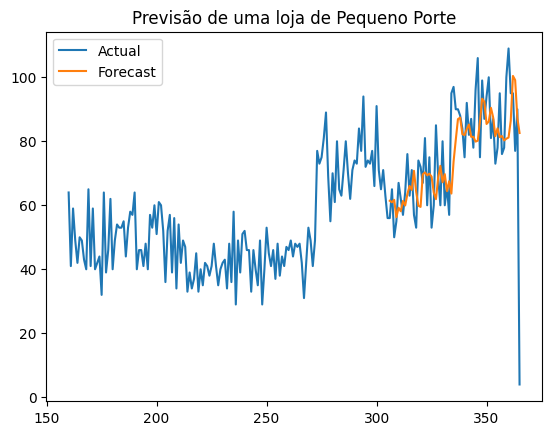

In [35]:
# Select the last 90 days of data for comparison
last_90_days = df2.iloc[-60:]


# Get the forecast for the next 60 days, including exogenous variables
forecast = sar.get_prediction(start=last_90_days.index[0], end=last_90_days.index[-1])

# Extract the predicted values for the next 60 days
predicted_values = forecast.predicted_mean

# Plot the actual sales and predicted values
plt.plot(df2[160:]['Quantidade Vendida'], label = 'Actual')
plt.plot(predicted_values.index, predicted_values, label='Forecast')
plt.title('Previsão de uma loja de Pequeno Porte')
plt.legend()
plt.show()

In [36]:
# Compare both Prophet accuracy

pred_SARIMA = predicted_values
actual = df2['Quantidade Vendida'][-60:]

# Define function to calculate mae, rmse

def mae(pred, actual):
    mae = np.mean(np.abs(pred - actual))
    return mae

def rmse(pred, actual):
    mse = np.mean((pred - actual) ** 2)
    rmse = np.sqrt(mse)
    return mse

def mape(pred, actual):
    absolute_percentage_errors = np.abs((actual - pred) / actual)
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

data = {
    'SARIMA': [mae(pred_SARIMA, actual), rmse(pred_SARIMA, actual), mape(pred_SARIMA, actual)],

}

df = pd.DataFrame(data, columns=['SARIMA'], index=['MAE', 'RMSE', 'MAPE'])
print(df)

# Calcule o MAPE para o modelo SARIMA
mape_SARIMA = mape(pred_SARIMA, actual)

# Exiba o MAPE calculado
print(f'MAPE para o modelo SARIMA: {mape_SARIMA:.2f}%')

# Calcule a acurácia como 100% menos o MAPE
accuracy_SARIMA = 100 - mape_SARIMA

# Exiba a acurácia
print(f'Acurácia do modelo SARIMA: {accuracy_SARIMA:.2f}%')

          SARIMA
MAE    10.471487
RMSE  237.556320
MAPE   44.548467
MAPE para o modelo SARIMA: 44.55%
Acurácia do modelo SARIMA: 55.45%
